In [ ]:
import torch, detectron2 

In [ ]:
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances("my_dataset_train", {}, "../test_data/finetune_detect-a-scroll/train/train.json", "../test_data/finetune_detect-a-scroll/train")
register_coco_instances("my_dataset_val", {}, "../test_data/finetune_detect-a-scroll/val/val.json", "../test_data/finetune_detect-a-scroll/val")

In [ ]:
train_metadata = MetadataCatalog.get("my_dataset_train")
train_dataset_dicts = DatasetCatalog.get("my_dataset_train")
val_metadata = MetadataCatalog.get("my_dataset_val")
val_dataset_dicts = DatasetCatalog.get("my_dataset_val")

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.OUTPUT_DIR = "../checkpoints"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 8
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 24  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 10000    # 1000 iterations seems good enough for this dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # Default is 512, using 256 for this dataset.
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # We have 4 classes.
# NOTE: this config means the number of classes, without the background. Do not use num_classes+1 here.
# Set the checkpoint period
cfg.SOLVER.CHECKPOINT_PERIOD = 500

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) #Create an instance of of DefaultTrainer with the given congiguration
trainer.resume_or_load(resume=True) #Load a pretrained model if available (resume training) or start training from scratch if no pretrained model is available


In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0003999.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0004499.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictorf = DefaultPredictor(cfg)

# new_im = cv2.imread("/Volumes/16TB_slow_RAID_0/Scroll3/PHerc0332.volpkg/volumes/20231027191953/00200.tif")
new_im = cv2.imread("/Users/jamesdarby/Documents/VesuviusScroll/GP/Vesuvius_Data_Download/Scroll4_PHerc_1667/PHerc1667.volpkg/volumes/20231107190228/00408.tif") 
#15100.tif is interesting 4499, 3999 works the best it seems
#22300.tif also fails pretty hard
outputs  = predictor(new_im)
outputsf = predictorf(new_im)

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(new_im[:, :, ::-1])
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

plt.imshow(out.get_image()[:, :, ::-1])
plt.show()

vf = Visualizer(new_im[:, :, ::-1])
outf = vf.draw_instance_predictions(outputsf["instances"].to("cpu"))

plt.imshow(outf.get_image()[:, :, ::-1])
plt.show()

In [48]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def dilate_mask(mask, dilation_percentage):
    kernel_size = int(max(mask.shape) * dilation_percentage / 100)
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    dilated_mask = cv2.dilate(mask, kernel, iterations=1)
    return dilated_mask

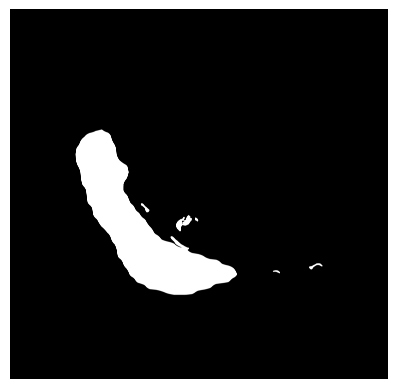

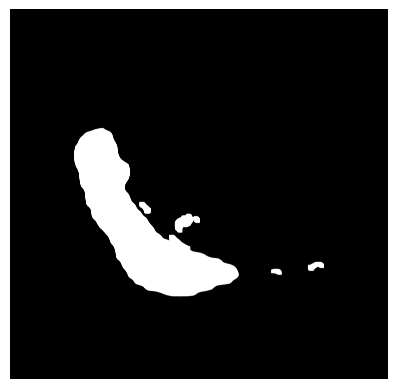

(7960, 8120)


In [58]:
masks = outputs["instances"].pred_masks.cpu().numpy()

combined_mask = np.logical_or.reduce(masks).astype(np.uint8)
plt.imshow(combined_mask, cmap='gray')
plt.axis('off')
plt.show()

kernel_size = (50, 50)
kernel = np.ones(kernel_size, np.uint8)


# Dilate the combined mask
dilated_mask = dilate_mask(combined_mask, 0.5)

plt.imshow(dilated_mask, cmap='gray')
plt.axis('off')
plt.show()

print(dilated_mask.shape)

In [ ]:
masked_image = np.copy(new_im)

In [ ]:
masked_image[~binary_mask] = 0

In [ ]:
plt.imshow(masked_image)

In [ ]:
Nmasked_image = np.copy(new_im)

In [ ]:
if len(Nmasked_image.shape) == 3:
    masked_image = Nmasked_image * np.stack([binary_mask] * 3, axis=-1)
else:
    masked_image = Nmasked_image * binary_mask

In [ ]:
plt.imshow(masked_image)

In [ ]:
output_folder = "/Users/jamesdarby/Documents/VesuviusScroll/GP/Vesuvius_Data_Download/Scroll4_PHerc_1667/masked_volumes"
output_file = output_folder + "masked_image.png"
cv2.imwrite(output_file, masked_image, [cv2.IMWRITE_PNG_COMPRESSION, 9])
